Parsing log file: ../../logs/generation_log_20250912_033659.txt...
Successfully parsed 640 data points.
Generating plot...


/tmp/ipykernel_2020055/1379825171.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='step', y='ddg', data=df, ax=ax, palette="coolwarm",



[INFO] Plot saved to: ../../results/optimization_plot_generation_log_20250912_033659.svg


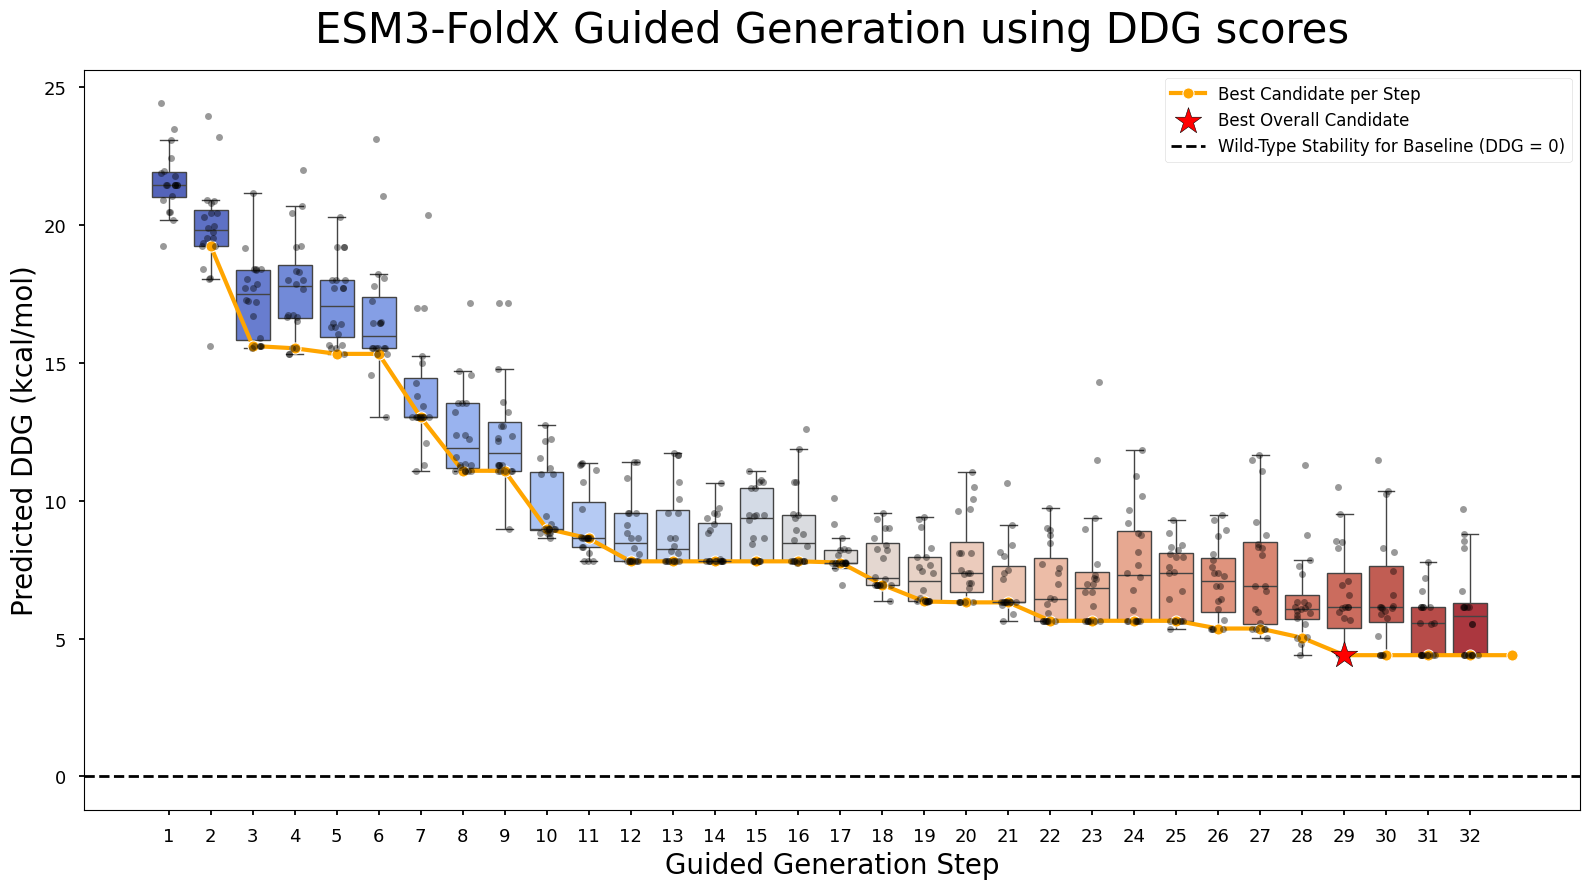

In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import os

def parse_log_file(filepath: str) -> pd.DataFrame:
    """
    Parses the detailed generation log file to extract step and ddG for each candidate.
    """
    print(f"Parsing log file: {filepath}...")
    
    data = []
    current_step = 0
    
 
    step_pattern = re.compile(r"--- Step (\d+) Denoised Results ---")
    ddg_pattern = re.compile(r"ddG:\s*([-\d\.]+)")

    with open(filepath, 'r') as f:
        for line in f:
            step_match = step_pattern.search(line)
            if step_match:
                current_step = int(step_match.group(1))
                continue

            ddg_match = ddg_pattern.search(line)
            if ddg_match and current_step > 0:
                ddg = float(ddg_match.group(1))
                data.append({'step': current_step, 'ddg': ddg})
    
    if not data:
        raise ValueError("Could not find any ddG results in the log file.")
        
    print(f"Successfully parsed {len(data)} data points.")
    return pd.DataFrame(data)

def create_optimization_plot(df: pd.DataFrame, save_path: str):
    """
    Creates a high-quality plot showing the ddG distribution, individual points,
    and the optimization trajectory.
    """
    print("Generating plot...")
    best_in_step = df.loc[df.groupby('step')['ddg'].idxmin()]
    best_overall = df.loc[df['ddg'].idxmin()]
    plt.style.use('seaborn-v0_8-talk')
    fig, ax = plt.subplots(figsize=(16, 9))

    sns.boxplot(x='step', y='ddg', data=df, ax=ax, palette="coolwarm",
                fliersize=0) 

    sns.stripplot(x='step', y='ddg', data=df, ax=ax, color='black',
                  alpha=0.4, jitter=0.2, size=5)


    sns.lineplot(x='step', y='ddg', data=best_in_step, ax=ax,
                 color='orange', marker='o', markersize=8,
                 linewidth=3, label='Best Candidate per Step')

    ax.scatter(best_overall['step'], best_overall['ddg'],
               marker='*', color='red', s=400,
               edgecolor='black', zorder=10, label='Best Overall Candidate')

    ax.axhline(0, color='black', linestyle='--', linewidth=2, label='Wild-Type Stability for Baseline (DDG = 0)')
    ax.set_title('ESM3-FoldX Guided Generation using DDG scores', fontsize=30, pad=20)
    ax.set_xlabel('Guided Generation Step', fontsize=20)
    ax.set_ylabel('Predicted DDG (kcal/mol)', fontsize=20)
    ax.legend(fontsize=12)
    
    ax.set_xticks(range(df['step'].min() -1 , df['step'].max()))
    ax.set_xticklabels(range(df['step'].min(), df['step'].max() + 1))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    print(f"\n[INFO] Plot saved to: {save_path}")
    plt.show()


if __name__ == "__main__":
    log_filename = "../../logs/generation_log_20250912_033659.txt"
    
    if not os.path.isfile(log_filename):
        print(f"[ERROR] Log file not found: {log_filename}")
        print("Please make sure this script is in the same directory as your log file.")
    else:
        results_df = parse_log_file(log_filename)
        results_dir = "../../results"
        os.makedirs(results_dir, exist_ok=True)
        log_basename = os.path.basename(log_filename)
        plot_filename = f"optimization_plot_{os.path.splitext(log_basename)[0]}.svg"
        plot_filepath = os.path.join(results_dir, plot_filename)
        
        create_optimization_plot(results_df, save_path=plot_filepath)